/home/necphy/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/necphy/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


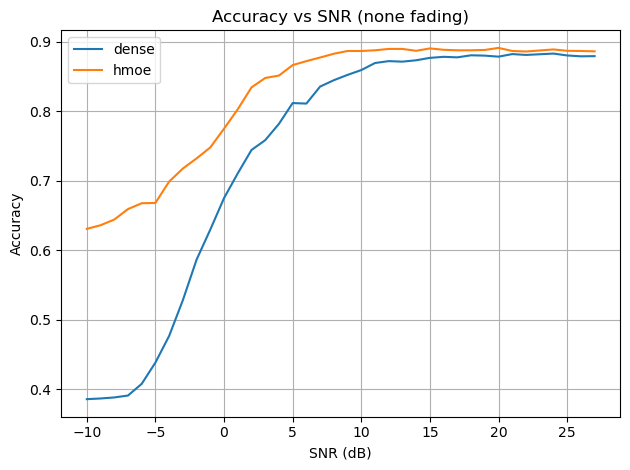

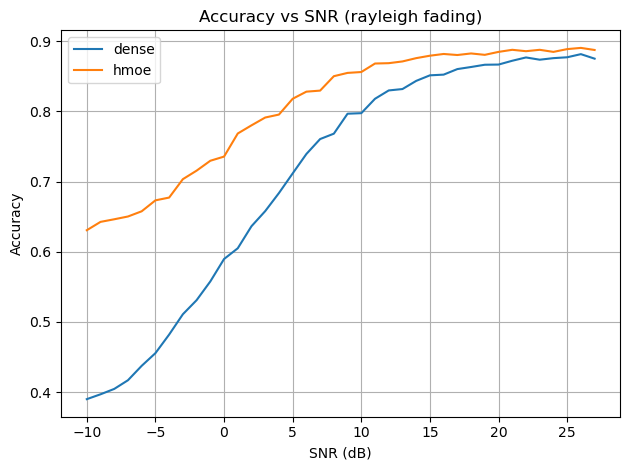

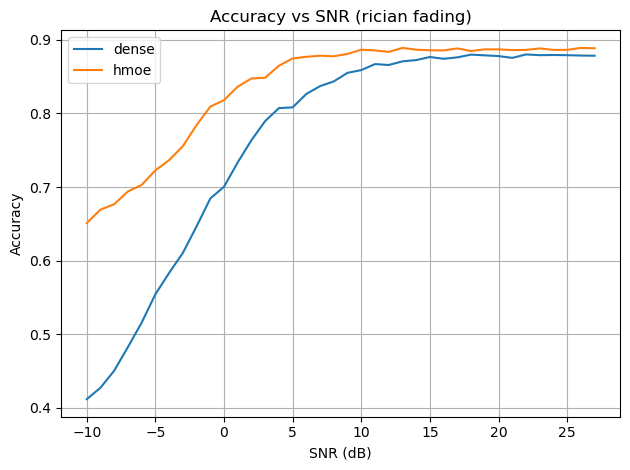

In [1]:
# fig1: acc vs snr, lines: models

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom  # assuming this class exists
from utils import collate_fn, SST2Dataset, fix_seed, QQPPromptDataset

# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(1997) # 2006
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
# model_moe = MoE_SemCom(num_tasks=2, embed_dim=380, task_dim=16, num_experts=8, transmit_dim=128, num_encd_layer=4).to(device) # currently 4 should be 6
# model_moe = Transformer_SemCom(num_tasks=2, embed_dim=412, task_dim=8, num_encd_layer=4, transmit_dim=256).to(device)

model_dense = Transformer_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_encd_layer=6, transmit_dim=128, num_heads=8).to(device)

model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

# model_moe.load_state_dict(torch.load("checkpoints/Dense_snr12_20250604_055257.pt"))

model_dense.load_state_dict(torch.load("checkpoints_new/Dense_sizeL_6_1_8_632_20250701_011126.pt", weights_only=True))
model_hetereo.load_state_dict(torch.load("checkpoints_new/HMoE_sizeL_6_12_8_632_20250702_084802.pt", weights_only=True)) 

# model_moe.eval()
model_dense.eval()
model_hetereo.eval()

# Load data
dataset = load_dataset("glue", "qqp")
batch_size = 512


# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

full_test_dataset = dataset["validation"]
subset_indices = random.sample(range(len(full_test_dataset)), len(full_test_dataset) // 10)
small_test_dataset = full_test_dataset.select(subset_indices)
test_dataset = QQPPromptDataset(small_test_dataset)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=16,
    pin_memory=True,
    persistent_workers=True,
)


snr_range = np.arange(-10, 28, 1)
fading_range = ['none', 'rayleigh', 'rician']

# Results dicts
results = {
    'dense': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    # 'moe': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hmoe': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},  #
}


# Main evaluation loop
for snr in snr_range:
    for fading in fading_range:
        metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

        for texts, labels in test_loader:
            # for arch_name, model in [('dense', model_dense), ('moe', model_moe), ('hetereoMoE', model_hetereo),]:  # NEW
            for arch_name, model in [('dense', model_dense), ('hmoe', model_hetereo),]:  # NEW

                for task in [0]:
                    with torch.no_grad():
                        if arch_name == 'dense':
                        # if True:
                            outputs, input_ids, _, _, _ = model(texts, task, float(snr), fading)
                        else:
                            outputs, input_ids, _, _, _, _, _ = model(texts, task, float(snr), fading) 


                        if task == 0:  # Classification
                            preds = outputs.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs.argmax(dim=-1).cpu().tolist()

                            tgt_ids_batch = input_ids[:, :len(pred_ids_batch[0])].cpu().tolist() 

                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=False)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=False)

                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)

        # Aggregate
        for arch_name in results.keys():
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total']
            bleu = np.mean(metrics[arch_name]['bleu_scores'])
            results[arch_name]['accuracy'][fading].append(acc)
            results[arch_name]['bleu'][fading].append(bleu)

# Plotting: 3 figures, one per fading
# model_types = ['dense', 'moe', 'hetereoMoE']  # NEW
model_types = ['dense', 'hmoe']  # NEW


for fading in fading_range:
    fig, axs = plt.subplots()

    # Accuracy plot
    for model in model_types:
        axs.plot(snr_range, results[model]['accuracy'][fading], label=model)
    axs.set_title(f'Accuracy vs SNR ({fading} fading)')
    axs.set_xlabel('SNR (dB)')
    axs.set_ylabel('Accuracy')
    axs.legend()
    axs.grid(True)

    # # BLEU plot
    # for model in model_types:
    #     axs[1].plot(snr_range, results[model]['bleu'][fading], label=model)
    # axs[1].set_title(f'BLEU Score vs SNR ({fading} fading)')
    # axs[1].set_xlabel('SNR (dB)')
    # axs[1].set_ylabel('BLEU Score')
    # axs[1].legend()
    # axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# fig 2: acc vs rician k factor, lines: models


In [ ]:
# fig 3: expert usage

In [ ]:
# fig 4: acc vs snr, lines: num of experts

In [ ]:
# table: flops vs acc

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pyldpc

class LDPCEncoder(nn.Module):
    def __init__(self, n=2400, d_v=2, d_c=4):
        super().__init__()
        self.H, self.G = pyldpc.make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
        self.k = self.G.shape[0]

    def forward(self, x):
        x_np = x.detach().cpu().numpy().astype(int)
        encoded = (x_np @ self.G) % 2
        return torch.tensor(encoded, dtype=torch.float32, device=x.device)

class LDPCDecoder(nn.Module):
    def __init__(self, H, max_iter=50):
        super().__init__()
        self.H = H
        self.max_iter = max_iter

    def forward(self, llr):
        llr_np = llr.detach().cpu().numpy().astype(np.float64)
        decoded = [pyldpc.decode(self.H, row, self.max_iter) for row in llr_np]
        decoded = torch.tensor(np.stack(decoded), dtype=torch.float32, device=llr.device)
        return (decoded > 0.5).float()

# Instantiate modules
encoder = LDPCEncoder(n=2400, d_v=2, d_c=4)
decoder = LDPCDecoder(encoder.H)

# Generate input
x = torch.randint(0, 2, (1, encoder.k)).float()
encoded = encoder(x)

# Simulate LLRs (no noise, just fake soft values)
llr = (1.0 - 2.0 * encoded) + torch.randn_like(encoded) * 0.01

# Decode
decoded = decoder(llr)

# Compare
print("Match: ", torch.equal(x, decoded))
if not torch.equal(x, decoded):
    print("Mismatch indices:", (x != decoded).nonzero(as_tuple=True))


Match:  False
Mismatch indices: (tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([   2,    4,    7,  ..., 2396, 2397, 2399]))


/home/necphy/miniconda3/lib/python3.11/site-packages/pyldpc/decoder.py:62: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  warnings.warn("""Decoding stopped before convergence. You may want
